# Flattening the Curve: Nonlinear Regression of COVID-19 Data

<br><br><br>
**Anton Zverev**

Last edited: 05/03/20


---

## How to use this notebook

In this notebook I've tried to create a user-friendly introduction to mathematical modeling of coronavirus data. The goal is *not* to draw conclusions about how fast coronavirus spreads, but instead to figure out what kind of model best describes case data. The process is broken down into several parts:
   1. [Importing the data](#sec1),
   2. [Seeing what the data looks like](#sec2),
   3. [Establishing terminology](#sec3),
   4. [Exploring what types of models might be useful](#sec4),
   5. [Fitting data to the models](#sec5),
   6. [Comparing them](#sec6), and finally
   7. [Visualizing the results](#sec7).

If you're viewing this notebook in `nbviewer`, all of the code cells are hidden by default to make reading easier. **You can toggle this feature to show/hide code by clicking the </> button in the top right corner of your browser.**

You can also download this notebook (either directly from `nbviewer` or from [github](https://github.com/antonymous21/Rona)) and run it locally, which will allow you to fit the most current data. Running the notebook yourself will also enable an interactive widget in part 7, which lets you visualize the data and the models for any country, US state, model type, and length of time.

All of the graphs in this notebook are created using [plotly](https://plotly.com/python/), which means that you can zoom, pan, trace, and hover on any plot right in your web browser.

---

<a id='sec1'></a>

## 1. Data Importation & Cleaning
<a id='sec1'></a>

In [1]:
import pandas as pd
import numpy as np
import inspect
from scipy import stats
from scipy import special
from math import sqrt
import time
import datetime

import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact
import plotly.offline as py
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

First, we import raw coronavirus case data from github. Here we use two different sources, one for state-by-state data in the US, and one for country-level data for the whole world. In this analysis we will only focus on the number of confirmed cases, not the number of deaths.

In [2]:
data_url_states = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
data_url_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

raw_df_states = pd.read_csv(data_url_states) # state-by-state data
raw_df_global = pd.read_csv(data_url_global) # country-by-country data

Next, we reformat the global data into a new dataframe `global_cumulative` so that it's easier to use and intepret. We'll also only focus on the top 50 most affected countries. Here's what the first few rows of the resulting dataframe look like:

In [3]:
raw_df_global.drop(columns=['Province/State','Lat','Long'],inplace=True)
raw_df_global.replace('US', 'United States',inplace=True)
raw_df_global = raw_df_global.groupby(by='Country/Region',as_index=True).agg(sum)
top_countries = raw_df_global.iloc[:,-1].sort_values(ascending=False).index[:50] # find top 50 countries

global_cumulative = raw_df_global.loc[top_countries,:].T # only take top countries, and transpose
global_cumulative.index.rename('date',inplace=True)
global_cumulative.columns.name = None
global_cumulative.index = pd.to_datetime(global_cumulative.index, format='%m/%d/%y') # fix timestamp
global_cumulative.sort_values(by='date',ascending=False,inplace=True)

global_cumulative.head(3)

,United States,Spain,Italy,United Kingdom,France,Germany,Turkey,Russia,Brazil,Iran,...,Bangladesh,Norway,Czechia,Dominican Republic,Colombia,Panama,Australia,South Africa,Egypt,Malaysia
date,,,,,,,,,,,,,,,,,,,,,
2020-05-02,1132539,216582,209328,183500,168518,164967,124375,124054,97100,96448,...,8790,7809,7755,7578,7285,7090,6799,6336,6193,6176
2020-05-01,1103461,213435,207428,178685,167305,164077,122392,114431,92202,95646,...,8238,7783,7737,7288,7006,6720,6778,5951,5895,6071
2020-04-30,1069424,213435,205463,172481,167299,163009,120204,106498,87187,94640,...,7667,7738,7682,6972,6507,6532,6766,5647,5537,6002


We likewise reformat the raw data from US states into a dataframe `states_cumulative`, with a separate column for each state. Here's what the first few rows of the resulting dataframe look like:

In [4]:
states_list = raw_df_states['state'].unique() # list of state abbreviations (50 states + 5 territories + DC)

raw_df_states['date'] = pd.to_datetime(raw_df_states['date'], format='%Y%m%d') # fix timestamp
raw_df_states = raw_df_states[['date','state','positive']] #extract the columns I care about

states_cumulative = raw_df_states[raw_df_states['state']=='AK'][['date','positive']]
states_cumulative.reset_index(drop=True,inplace=True)

for s in states_list:
    state_data = raw_df_states[raw_df_states['state']==s]['positive']
    states_cumulative[s] = state_data.reset_index(drop=True)

states_cumulative.set_index('date',inplace=True) # index by date
states_cumulative.drop(columns='positive',inplace=True)
states_cumulative.fillna(value=0,inplace=True) # nan values will mess up the regression later
states_cumulative = states_cumulative.loc[:,(states_cumulative.iloc[0,:]>100).values] # remove states with <100 cases
states_list = states_cumulative.columns

states_cumulative.head(3)

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2020-05-03,368.0,7725.0,3431.0,8640.0,53616.0,16225.0,29287.0,5016.0,5208.0,36078.0,...,2631.0,13177.0,31548.0,5175.0,18671.0,897.0,15003.0,7964.0,1191.0,579.0
2020-05-02,365.0,7434.0,3372.0,8364.0,52197.0,15768.0,28764.0,4797.0,5038.0,35463.0,...,2588.0,12661.0,30522.0,4981.0,17731.0,886.0,14637.0,7660.0,1169.0,566.0
2020-05-01,364.0,7158.0,3321.0,7962.0,50442.0,15284.0,28764.0,4658.0,4918.0,34728.0,...,2525.0,11891.0,29229.0,4828.0,16901.0,879.0,14327.0,7314.0,1136.0,559.0


We now have two data sets, one for US states and one for countries. Conveniently, the data sources are updated daily, so re-running this notebook automatically pulls the most current data!

<a id='sec2'></a>

## 2. Data Visualization

Let's now see what the data looks like. Besides the number of cumulative confirmed cases, it will also be helpful to look at the case increase per day. This is defined as the difference between the cumulative case counts on consecutive days. We will store this data in `states_inc` and `global_inc`, and a smoothed (rolling 3-day average) version of the same data in `states_inc_rolling3` and `global_inc_rolling3`.

In [5]:
states_inc = states_cumulative.diff(periods=-1)
states_inc_rolling3 = (states_inc.shift(-1)+states_inc.shift(1)+states_inc)/3
states_inc_rolling3.dropna(inplace=True)

global_inc = global_cumulative.diff(periods=-1)
global_inc_rolling3 = (global_inc.shift(-1)+global_inc.shift(1)+global_inc)/3
global_inc_rolling3.dropna(inplace=True)

For regression analysis, we will need the dependent variable, time, to be numeric, so we create `x_data`, which is the number of days that have passed since the beinning of the year. `x_data_global` is the same thing for the global dataframe. Note that the two data sets have different starting dates.

In [6]:
x_data = states_cumulative.index.to_series().dt.dayofyear
x_data_global = global_cumulative.index.to_series().dt.dayofyear

Let's now visualize some of our data! States first:

In [7]:
subset = ['CA','NY','NJ']
colors = pc.DEFAULT_PLOTLY_COLORS

fig = make_subplots(rows=1, cols=2)
for i,s in enumerate(subset):
    fig.add_trace(go.Scatter(name=s,x=x_data,y=states_cumulative[s],mode='lines',line_color=colors[i],showlegend=True),row=1,col=1)
    fig.add_trace(go.Scatter(name=s,x=x_data,y=states_inc_rolling3[s],mode='lines',line_color=colors[i],showlegend=False),row=1,col=2)

fig.update_layout(height=350,margin=dict(l=20, r=20, t=50, b=20))
fig.update_xaxes(title='Day of Year',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title='Cumulative Case Count Over Time',row=1,col=1)
fig.update_yaxes(title='Daily Incidence Over Time',row=1,col=2)
fig.show()

And we can do the same for countries:

In [8]:
subset = global_cumulative.columns[:3]

fig = make_subplots(rows=1, cols=2)
for i,s in enumerate(subset):
    fig.add_trace(go.Scatter(name=s,x=x_data,y=global_cumulative[s],mode='lines',line_color=colors[i],showlegend=True),row=1,col=1)
    fig.add_trace(go.Scatter(name=s,x=x_data,y=global_inc_rolling3[s],mode='lines',line_color=colors[i],showlegend=False),row=1,col=2)

fig.update_layout(height=350,margin=dict(l=20, r=20, t=50, b=20))
fig.update_xaxes(title='Day of Year',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title='Cumulative Case Count Over Time',row=1,col=1)
fig.update_yaxes(title='Daily Incidence Over Time',row=1,col=2)
fig.show()

Now that we know what the case curves look like, we can attempt to do some modeling.

<a id='sec3'></a>

## 3. Disease Modeling Basics

Before we go further let's clarify some terminology.

>**Daily incidence**: the number of new cases that are diagnosed every day. This represents how many new people are becoming infected every day, assuming testing is accurate. It's described in more detail [here](https://en.wikipedia.org/wiki/Incidence_(epidemiology)).

>**Cumulative case count**: the number of cumulative cases every day. This represents how many total people have been infected up until a certain day, again assuming that testing is accurate.

The graphs we just plotted above were the *cumulative case count* over time and the *daily incidence* over time, respectively. They are two different representations of the same data; the former is just the sum of the latter. Mathematically speaking, the cumulative case count at a certain day is the integral of the incidence up to that day. Equivalently, the incidence at a certain day is the derivative of the cumulative incidence on that day. We'll revisit that thought in a bit.

You may notice that the cumulative case counts look like they are increasing exponentially. In the early days of the outbreak, experts warned the public about such [exponential growth](https://en.wikipedia.org/wiki/Exponential_growth).

But wait! An important property of an exponential is that its derivative and integral is also an exponential. If the cumulative case count were really increasing exponentially, then the daily incidence would be, too. But you can clearly see in the graphs above that the daily incidence first rises and then falls. It looks like a jagged hump. In fact, the daily incidence somewhat resembles a *bell curve*.

You may have seen coronavirus graphs in the news that look something like this:

In [9]:
normal_1 = stats.norm(loc = 5, scale = 1) # gaussian with mean = 5, std = 1
normal_2 = stats.norm(loc = 10, scale = 3) # gaussian with mean = 10, std = 3
x = np.arange(0,20,0.1)

fig = go.Figure()
fig.add_trace(go.Scatter(name='Fast spread',x=x,y=normal_1.pdf(x),mode='lines'))
fig.add_trace(go.Scatter(name='Slow spread',x=x,y=normal_2.pdf(x),mode='lines'))
fig.update_layout(width=600,height=350,margin=dict(l=20, r=20, t=50, b=20))
fig.update_xaxes(title='Days',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title='Number of new cases',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.show()

Look's familiar right? Well, it turns out that when disease outbreaks happen, the daily incidence generally looks hump-shaped like that. The basic explanation is that in the beginning, very few people have the disease, but each person can infect several other people. The incidence increases exponentially as each new infected person infects many more people. Eventually, the incidence reaches a maximum, or peak. Let's define it:
>**Turning point, $t_i$**: the point at which the daily incidence reaches its peak, or "flattens out".

The turning point can be thought of as a saturation point, where so many people have the disease that the amount of new people available to be infected starts getting smaller. This process continues, and the daily incidence continues to decrease until it reaches zero (the outbreak is over).

So, we have a rough idea of what daily incidence numbers should look like over time. What should the cumulative case count look like? Well, it's the integral of a bell curve:

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(name='Fast spread',x=x,y=normal_1.cdf(x),mode='lines'))
fig.add_trace(go.Scatter(name='Slow spread',x=x,y=normal_2.cdf(x),mode='lines'))
fig.update_layout(width=600,height=350,margin=dict(l=20, r=20, t=50, b=20))
fig.update_xaxes(title='Days',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title='Number of cumulative cases',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.show()

We see that the cumulative case curve is S-shaped and monotonically increasing – first rapid growth, then slow growth that approaches a plateau. Depending on how fast the spread of the disease is, the curve can be steeper or shallower. Also notice that the turning point, which was the maximum on the daily incidence graph, is the inflection point on the cumulative case count graph.

Now, let's get more precise with our math. The curves illustrated above are actually examples of continuous variable distributions, with the following analogies:
>Daily incidence over time can be thought of as a **probability density function [(PDF)](https://en.wikipedia.org/wiki/Probability_density_function)**, which we will call $\phi(t)$.

>Cumulative case count over time can be thought of as a **cumulative distribution function [(CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function)**, which we will call $\Phi(t)$.

Generally speaking, for any "hump-shaped" PDF we will observe a [sigmoidal](https://en.wikipedia.org/wiki/Sigmoid_function) CDF, because $\Phi(t)=\int_0^t\phi(\tau)d\tau$, as mentioned earlier. In disease modeling, $\Phi(t)$ is often called a **growth curve**.

<a id='sec4'></a>

## 4. Types of Models

Going forward, we will try to fit case data to mathematical growth curves. There exist a number of strategies for [infectious disease modeling](https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease), and more advanced types of models, including [compartmental models like SIR](https://www.sciencedirect.com/science/article/pii/S0378437103012287), can be used. However, here we will simply describe growth curves with mathematical functions, which has the advantage of being easier to implement, interpret, and rationalize.

The question then is the following: what mathematical function best describes our coronavirus data? We saw above that a bell curve seems like a reasonable guess for $\phi(t)$, but there might be other functions that look similar.

To my knowledge, no comprehensive work has been published to date that answers this question, although I did find [one recent pre-print](https://arxiv.org/abs/2003.00507) analyzing this same question. The authors focused only on a handful of countries and a handful of models, on data through the end of March.

So, we need to find a few reasonable functions and define their PDFs and growth curves. There are at least two mathematical functions that are suitable:

>**Normal** distribution [(link)](https://en.wikipedia.org/wiki/Normal_distribution), also called a Gaussian distribution or bell curve, defined by:

$$ \phi(t) = \frac{N}{s \sqrt{2 \pi}} e^{-\frac{1}{2}  (t-t_0)^2/s^2 } $$ 
$$ \Phi(t) = \frac{N}{2} + \frac{N}{2} \operatorname{erf}\left(\frac{t-t_0}{s \sqrt{2}}\right) $$

>**Logistic** distribution [(link)](https://en.wikipedia.org/wiki/Logistic_distribution), commonly used to model population growth in biology, defined by:

$$ \phi(t) = \frac{N}{4s} \operatorname{sech}^2 \left( \frac{t-t_0}{2s} \right) $$ 
$$ \Phi(t) = \frac{N}{1 + e^{-(t-t_0)/s}} $$


where $N$ is the final number of total cases, $t_0$ is a location parameter (equal to the turning point, $t_i$, for these distributions), and $s$ is a scale parameter related to the steepness of the growth curve. The [error function](https://en.wikipedia.org/wiki/Error_function), $\operatorname{erf}(x)$, is a special function that appears commonly in statistics but has no closed form.

Let's visualize these distributions for $N=1$ and $t_i=10$. Note that the values of $s$ are different for each distribution because the maning of $s$ isn't directly comparable between the distributions.

In [11]:
logistic_1 = stats.logistic(loc=10,scale=1.8)

fig = make_subplots(rows=1, cols=2,subplot_titles=('PDF comparison','CDF comparison'))
fig.add_trace(go.Scatter(name='Normal',x=x,y=normal_2.pdf(x),mode='lines',line_color=colors[0],showlegend=True),row=1,col=1)
fig.add_trace(go.Scatter(name='Logistic',x=x,y=logistic_1.pdf(x),mode='lines',line_color=colors[1],line_dash='dash',showlegend=True),row=1,col=1)
fig.add_trace(go.Scatter(name='Normal',x=x,y=normal_2.cdf(x),mode='lines',line_color=colors[0],showlegend=False),row=1,col=2)
fig.add_trace(go.Scatter(name='Logistic',x=x,y=logistic_1.cdf(x),mode='lines',line_color=colors[1],line_dash='dash',showlegend=False),row=1,col=2)

fig.update_layout(height=350,margin=dict(l=20, r=20, t=50, b=20))
fig.update_xaxes(title='Days',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title='Probability density',row=1,col=1)
fig.update_yaxes(title='Probability',row=1,col=2)
fig.show()

You can see that two distributions are very close to each other for this specific choice of parameters. The normal distribution has thinner tails while the logistic distribution has thicker tails.

These curves are great for describing the progression of an idealized disease. But one potential problem is that these models are perfectly *symmetric*, which means that the incidence increases just as quickly as it decreases. We don't necessarily know that to be the case; in fact, we might expect that the incidence should decrease more slowly than it increases, because towards the end of an outbreak it takes longer and longer to find new people to infect as disease control measures are implemented. This *right skew* is in fact what is observed in many epidemics.

So, we may want to test some growth curves that are asymmetric. Luckily, there are some generalizations of the distributions described above that can introduce skew:

>**Skew normal** distribution [(link)](https://en.wikipedia.org/wiki/Skew_normal_distribution), defined by:

$$ \Phi(t) = N \left[ \frac{1}{2} + \frac{1}{2} \operatorname{erf}\left(\frac{t-t_0}{s \sqrt{2}}\right) - 2 T \left(\frac{t-t_0}{s},a \right) \right] $$

>**Richards** curve [(link)](https://en.wikipedia.org/wiki/Generalised_logistic_function), a type of generalized logistic curve [used in some disease models](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3293463/), defined by:

$$ \Phi(t) = \frac{N}{\left(1 + e^{-(t-t_0)/s+\operatorname{ln}(a)} \right)^{1/a}} $$

>**Log logistic** distribution [(link)](https://en.wikipedia.org/wiki/Shifted_log-logistic_distribution), a different type of skewed logistic, defined by:

$$ \Phi(t) = \frac{N}{ 1 + \left(1+ \frac{a(t-t_0)}{s}\right)^{-1/a}} $$

>**Inverse Weibull** distribution [(link)](https://link.springer.com/article/10.1007/s00362-009-0271-3), used in several fields of engineering, defined by:

$$ \Phi(t) = N e^{-\left(\frac{s}{t-t_0}\right)^a} $$

>**Gompertz** curve [(link)](https://en.wikipedia.org/wiki/Gompertz_function), a special case of the generalized logistic [sometimes applied in biology](https://www.tandfonline.com/doi/pdf/10.1080/09712119.2016.1268965), defined by:

$$ \Phi(t) = N e^{-e^{-(t-t_0)/s}} $$

where $N$ is the final number of total cases, $t_0$ is a location parameter related to the turning point, $s$ is a scale parameter related to the rate of growth, and $a$ is a skewness parameter related to the asymmetry of the growth. The interpretations of $t_0$, $s$, and $a$ and their relations to $t_i$ vary depending on the model. The skew normal uses [Owen's T function](https://en.wikipedia.org/wiki/Owen%27s_T_function), $T(h,a)$, a special function that has no closed form.

Here are example plots for two of the skewed models:

In [12]:
richards = stats.genlogistic(c=9,loc=4,scale=2.5)
skewnorm = stats.skewnorm(a=3,loc=7,scale=5)

fig = make_subplots(rows=1, cols=2,subplot_titles=('PDF comparison','CDF comparison'))
fig.add_trace(go.Scatter(name='Skew normal',x=x,y=skewnorm.pdf(x),mode='lines',line_color=colors[0],showlegend=True),row=1,col=1)
fig.add_trace(go.Scatter(name='Richards',x=x,y=richards.pdf(x),mode='lines',line_color=colors[1],line_dash='dash',showlegend=True),row=1,col=1)
fig.add_trace(go.Scatter(name='Skew normal',x=x,y=skewnorm.cdf(x),mode='lines',line_color=colors[0],showlegend=False),row=1,col=2)
fig.add_trace(go.Scatter(name='Richards',x=x,y=richards.cdf(x),mode='lines',line_color=colors[1],line_dash='dash',showlegend=False),row=1,col=2)

fig.update_layout(height=350,margin=dict(l=20, r=20, t=50, b=20))
fig.update_xaxes(title='Days',showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title='Probability density',row=1,col=1)
fig.update_yaxes(title='Probability',row=1,col=2)
fig.show()

As with the symmetric models, there are subtle differences between the skewed curves. This may mean that some models will fit the data more accurately than others, and that's what we want to find out!

We've now identified **7** different mathematical functions. The normal and logistic models are symmetric, while the skew normal, Richards, log logistic, inverse Weibull, and Gompertz models are asymmetric. We can now attempt to fit these to coronavirus case data.

**Note**: theoretically there should be no difference whether we fit daily incidence data to $\phi$ or cumulative case count data to $\Phi$. However, based on the graphs of real coronavirus data in Part 2, we can see that daily incidence data is very noisy. It has a significantly higher noise-to-signal ratio than the cumulative case count data, so it will be more susceptible to overfitting and outlier influence. We should therefore perform our fits using the cumulative case count data, which is in line with standard practice in [disease modeling](https://www.sciencedirect.com/science/article/abs/pii/S1571064516300641).

<a id='sec5'></a>

## 5. Data Fitting

First we need to define all the functions described above. Although `scipy.special` has built-in objects for most of these models, calling them is much more computationally expensive than defining them ourselves using `np.erf`, `np.exp` and `np.log`.

All of these $\Phi$ functions take an array of time points `t` as a first argument, followed by their distributon parameters (`N`, `t_i`, `s`, and `a` where appropriate). Again, it's important to note that although they have the same names, the values for `t_i`,`s`, and `a` are not directly comparable between different model types without some more detailed analysis.

In [13]:
def normal(t, N, t_0, s):
    """
    Returns the normal growth curve evaluated at every time value in t.
    t_0 is the mean of the corresponding PDF and s is the standard deviation.
    """
    return (N/2 * (1 + special.erf((t - t_0)/(s*sqrt(2)))))

def logistic(t, N, t_0, s):
    """
    Returns the logistic growth curve evaluated at every time value in t.
    t_0 is the mean of the corresponding PDF and s*pi/sqrt(3) is the standard deviation.
    """
    return (N / (1 + np.exp(-(t - t_0)/s)))

def skewnorm(t, N, t_0, s, a):
    """
    Returns the skew normal growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    Non-negative values of a correspond to right-skew, and a = 0 is equivalent to normal(t, N, t_0, s).
    """
    return N*(normal(t,1,t_0,s)-2*special.owens_t(((t-t_0)/s),a))

def richards(t, N, t_0, s, a):
    """
    Returns the Richards growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    a must be positive, with a < 1 corresponding to right-skew. a = 1 is equivalent to logistic(t, N, t_0, s).
    """
    return N / np.power((1 + np.exp(np.log(a)-(t-t_0)*a/s)),(1/a))

def loglogistic(t, N, t_0, s, a):
    """
    Returns the log logistic growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    a must be positive and always lead to right-skew. As a approaches 0, loglogistic approaches logistic(t, N, t_0, s).
    """
    cutoff = t_0 - s/a # the cdf is only necessarily nonnegative at t values above this cutoff
    cdf = np.array([N / (1 + (1 + a*(idx-t_0)/s)**(-1/a)) if idx > cutoff else 0 for idx in t])
    return cdf

def invweibull(t, N, t_0, s, a):
    """
    Returns the inverse Weibull growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    a must be positive and always leads to right-skew.
    """
    return np.array([N * np.exp(-(s/(idx - t_0))**a) if idx > t_0 else 0 for idx in t])

def gompertz(t, N, t_0, s):
    """
    Returns the Gompertz growth curve evaluated at every time value in t.
    t_0 is related to the mean of the corresponding PDF and s is related to the standard deviation.
    """
    return N * np.exp(-np.exp(-(t-t_0)/s))

model_list = [normal, logistic, skewnorm, richards, loglogistic, invweibull, gompertz]

Next, we need a nonlinear `regression` function that will fit the data to whichever model is specified. We can use `scipy.least_squares` to find the parameter weights that minimize the model's loss (the square of the residuals). In this function we also provide reasonable starting guesses for each parameter, which differ depending on the type of model.

In [14]:
def get_params(model):
    return list(inspect.signature(model).parameters.keys())[1:]

def regression(model,x_test,y_test):
    
    def residual(x, t, y):
        return model(t,*x) - y
    
    x0 = [y_test.max()*1.2,x_test.max()*0.8,1]
    x_min = [y_test.max(),x_test.min(),0]
    x_max = [np.inf,np.inf,np.inf]
    if len(get_params(model)) == 4:
        # append min, max, and starting values for the 'a' parameter
        x_min.append(0)
        if model.__name__ == 'skewnorm':
            x0.append(0.1)
            x_max.append(10) # personal choice
        elif model.__name__ == 'richards':
            x0.append(0.9)
            x_max.append(1)
        elif model.__name__ == 'loglogistic':
            x0.append(0.1)
            x_max.append(2) # personal choice
        elif model.__name__ == 'invweibull':
            x0.append(1.1)
            x_max.append(10) # personal choice
    
    res_lsq = least_squares(residual, x0, bounds=(x_min,x_max),
            ftol=1e-10, xtol=1e-10, gtol=1e-10, loss='linear', args=(x_test, y_test))
    return res_lsq.x # returns array of parameter values


We also need a way of quantifying how closely the predictions match the actual data. So, we can define a function called `score_model`, which will return the [root-mean-squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation), as well as the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion), giving us 3 different metrics to evaluate how good the models were.

In [15]:
def score_model(y, y_hat, k):
    sse = np.sum((y-y_hat)**2)
    n = len(y)
    rmse = np.sqrt(sse/n)
    aic = n*np.log(sse/n)+2*k
    bic = n*np.log(sse/n)+k*np.log(n)
    return rmse, aic, bic

Finally, we define `fit_data` to iterate over every state or country and run `regression` on that region's incidence data. This function returns a dataframe with the predicted values of the fit parameters for each region, as well as model evaluation criteria. The dataframe also includes figure handles to simple plots comparing the model to the actual data for each region, although we will do more comprehensive visualization later. 

In [16]:
def fit_data(df,regions,region_type,model,x_test):
    start = time.time()
    param_names = get_params(model)
    k = len(param_names)
    param_vals = [[] for i in range(k)]
    rmse_vals = []
    aic_vals = []
    bic_vals = []
    figs = []
    for item in regions:
        y_test = df[item].values
        params = regression(model,x_test,y_test)
        [param_vals[i].append(params[i]) for i in range(k)]
        y_pred = model(x_test,*params)
        rmse, aic, bic = score_model(y_test,y_pred,k)
        rmse_vals.append(rmse)
        aic_vals.append(aic)
        bic_vals.append(bic)

        f = plt.figure()
        plt.plot(x_test,y_pred,'--')
        plt.plot(x_test,y_test)
        plt.xlabel('Day of Year')
        plt.ylabel('Cumulative Case Count')
        plt.title('Cases in '+item)
        plt.legend(['Model Fit','Actual Numbers'])
        figs.append(f)
        plt.close(f)
        
    fit_info = pd.DataFrame(index=regions,data={param_names[i]:param_vals[i] for i in range(k)})
    fit_info['fig'] = figs
    fit_info['rmse'], fit_info['aic'], fit_info['bic'] = rmse_vals, aic_vals, bic_vals
    fit_info.index.rename(region_type,inplace=True)
    fit_info.sort_values(by='N',ascending=False,inplace=True)
    
    end = time.time()
    print(model.__name__ + ' finished in %.1f sec' % (end-start))
    
    return fit_info

np.seterr(all='ignore');

Now we can can go ahead and call `fit_data` on both the state data and the country data. Because we have several different fit functions, we need to run `fit_data` several times for every region. We can store one dataframe associated with each model type in the dictionaries `state_info` and `global_info`. We can also see how long each model takes to run by looking at the displayed output.

In [17]:
state_info = {m.__name__:fit_data(states_cumulative,states_list,'State',m,x_data.values) for m in model_list}

normal finished in 2.9 sec
logistic finished in 2.5 sec
skewnorm finished in 6.0 sec
richards finished in 6.4 sec
loglogistic finished in 24.0 sec
invweibull finished in 29.4 sec
gompertz finished in 2.6 sec


In [18]:
global_info = {m.__name__:fit_data(global_cumulative,top_countries,'Country',m,x_data_global.values) for m in model_list}

normal finished in 2.4 sec
logistic finished in 3.1 sec
skewnorm finished in 7.0 sec
richards finished in 7.7 sec
loglogistic finished in 23.3 sec
invweibull finished in 25.2 sec
gompertz finished in 2.7 sec


Here's what a few of the resulting dataframes look like:

In [19]:
state_info['gompertz'].head()

,N,t_0,s,fig,rmse,aic,bic
State,,,,,,,
MN,1.885681e+10,706.378979,215.559297,Figure(432x288),140.219700,589.298836,595.531448
NE,1.359842e+10,554.750368,159.941224,Figure(432x288),67.322688,502.720681,508.953294
IA,6.070847e+06,285.937003,86.583316,Figure(432x288),87.114137,533.131863,539.364476
KS,7.507249e+05,257.891372,82.965677,Figure(432x288),104.204949,554.270435,560.503048
NY,3.622924e+05,97.304113,13.750852,Figure(432x288),2133.099417,910.509097,916.741709


In [20]:
global_info['gompertz'].head()

,N,t_0,s,fig,rmse,aic,bic
Country,,,,,,,
Brazil,5.640542e+06,211.110190,62.828004,Figure(432x288),782.439844,1365.133077,1373.007995
Ecuador,3.268906e+06,233.186138,71.139625,Figure(432x288),1201.318342,1452.599670,1460.474588
Qatar,2.715235e+06,243.134283,73.110483,Figure(432x288),148.844352,1026.591833,1034.466752
United States,1.508376e+06,103.298256,16.908293,Figure(432x288),7685.220429,1831.199085,1839.074004
Pakistan,8.123061e+05,212.886863,67.784742,Figure(432x288),181.170646,1066.685634,1074.560553


And, for reference, here's what one of the fits look like when plotted alongside the actual data:

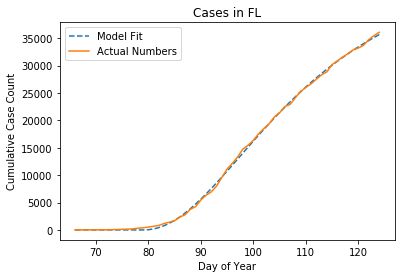

In [21]:
state_info['loglogistic'].loc['FL','fig']

We'll make a nicer visualization in Part 7 after we've compared the different models.

<a id='sec6'></a>

## 6. Model Comparison

Now, we need a way to compare the models to each other. We could try to look at every single plot and visually identify which of the models looks better. But that's not quantitative, and it's also not feasible for 7 models and 100 total regions.

Luckily, we have already computed the RMSE, AIC, and BIC for each model fit for each region. These criteria characterize how closely the predictions match the data, and the smaller the values the better the fit. Unfortunately, the magnitudes of the RMSE, AIC, and BIC might be different for each region because of the large difference in the magnitude of case counts. To handle this, we can [standardize](https://en.wikipedia.org/wiki/Standard_score) the criteria scores across different regions.

For example, to standardize the RMSE for a region, we first subtract the average RMSE for that region from each model's RMSE, and then divide by the standard deviation of the RMSE for the same region. This is accomplished with `compare_models`.

In [22]:
def compare_models(fit_dict,criterion,standardize=True):
    c = pd.DataFrame([m[1][criterion] for m in fit_dict.items()],index=fit_dict.keys())
    if standardize:
        c = (c-c.mean())/c.std()
    return c.T

Now we can see the standardized RMSE scores for both states and countries. Note that for each region, a positive score means that model was worse than the other models. A negative score means that the model was better than the rest for that region. A score of 0 means that the model was exactly average compared to the rest (for that region). Here's what the standardized RMSE dataframe looks like for a few states:

In [23]:
state_rmses = compare_models(state_info,'rmse',standardize=True)
state_rmses.head(3)

,normal,logistic,skewnorm,richards,loglogistic,invweibull,gompertz
MN,-0.380638,-0.444504,-0.394521,-0.441885,-0.266382,2.263427,-0.335496
NE,-0.374651,-0.453632,-0.394118,-0.450944,-0.285755,2.262999,-0.303899
NY,1.002037,1.820834,-0.676036,-0.481525,-0.763712,-0.420002,-0.481597


Again, the best model for a region is the one with the most negative standardized score. Here's what the same analysis looks like for a few countries:

In [24]:
global_rmses = compare_models(global_info,'rmse')
global_rmses.head(3)

,normal,logistic,skewnorm,richards,loglogistic,invweibull,gompertz
United States,0.90001,1.780869,-0.963977,-0.136331,-0.654163,-0.790012,-0.136395
Brazil,-0.33843,0.723338,-0.396918,-0.496209,-0.891071,1.961680,-0.562390
Ecuador,-0.03258,-0.708657,-0.032580,-0.708657,-0.704552,2.119562,0.067465


Clearly, different models do better for different regions. We can get a sense of how well each model did by plotting the distribution of standardized scores with a [violin plot](https://en.wikipedia.org/wiki/Violin_plot). For this analysis we focus only on the RMSE, because it's the easiest to interpret.

To reiterate, what we're looking for is a model with the lowest standardized RMSE scores for as many states and countries as possible.

In [25]:
fig = make_subplots(rows=2, cols=1)
label = '%{customdata}: %{y:.2f}<extra></extra>'

for i,m in enumerate(state_rmses.columns):
    fig.add_trace(go.Violin(y=state_rmses[m], name=m, box_visible=False, meanline_visible=True, bandwidth=0.2,
                            hoveron='points', customdata = state_rmses.index.values,hovertemplate=label,
                            points='all',jitter=0.1,pointpos=0,line_color=colors[i]),row=1,col=1)
    
    fig.add_trace(go.Violin(y=global_rmses[m],name=m,box_visible=False,meanline_visible=True, bandwidth=0.2,
                            hoveron='points', customdata = global_rmses.index.values,hovertemplate=label,
                            points='all',jitter=0.1,pointpos=0,line_color=colors[i]),row=2,col=1)
    

fig.update_layout(height=700,title_text="Comparison of Models on State & Country Data",title_x=0.5,showlegend=False)
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', mirror=True)
fig.update_yaxes(title="Standard RMSE Score by State",row=1,col=1)
fig.update_yaxes(title="Standard RMSE Score by Country",row=2,col=1)
fig.show()


What's the verdict? Out of the symmetric models, the normal model seems to score a bit lower (i.e. better) than the logistic model. But the asymmetric models are significantly better! The skew normal model has a lower error than the normal model for every region, and the Richards model has a lower error than the logistic model. The log logistic model also seems really good, except for a few outliers. The inverse Weibull and Gompertz models are not as consistently good.

This lends credibility to the hypothesis that incidence data is not symmetric, and generally follows a right-skew distribution. Out of the asymmetric models, either Richards or loglogistic could be good. Note, however, that in terms of computational runtime, the log logistic fit was significantly slower.

<a id='sec7'></a>

## 7. Visualizing Results

Below, you can see the fits visualized for a few regions.

In [26]:
def show_region(dataset,model,region,month):
    
    if dataset=='state':
        df = state_info
        cum = states_cumulative
        x = x_data
    elif dataset=='country':
        df = global_info
        cum = global_cumulative
        x = x_data_global
    
    start = pd.Timestamp(x.index.values[-1])
    end = pd.to_datetime('2020-'+str(month)+'-28')
    delta = (end-start).days
    dates = [start+datetime.timedelta(n) for n in range(delta)]
    dates_numeric = np.arange(x.values[-1],x.values[-1]+delta,1)
    
    params = df[model].loc[region,:].values[:-4]
    y_pred = go.Scatter(name=model+' fit',x=dates,y=globals()[model](dates_numeric,*params),mode='lines',line=dict(dash="dash"))
    y_real = go.Scatter(name='actual cases in '+region,x=x.index,y=cum[region].values,mode='lines')
    layout = dict(xaxis=dict(title="Day of Year"),yaxis=dict(title="Cumulative Case Count in "+region),
                  width=700,height=400,margin=dict(t=30))
    
    fig = go.Figure([y_pred, y_real],layout=layout)
    fig.add_shape(name='current',type="line", x0=x.index[0], x1=x.index[0], y0=0, y1=params[0],
                  line=dict(width=1,dash="dot"))
    
    fig.update_xaxes(showgrid=True, showline=True, linewidth=1.5, linecolor='black', mirror=True)
    fig.update_yaxes(showgrid=False, showline=True, linewidth=1.5, linecolor='black', mirror=True)
    fig.show()


In [27]:
show_region('state','richards','MA',7)

In [28]:
show_region('country','loglogistic','Iran',5)

If you run this notebook locally, you'll also be able to see an interactive widget below. This will let you visualize the data and the model fits, allowing you to change the state/country, the model type, and the end date.

In [29]:
interact(show_region,dataset='state',model=list(state_info.keys()), 
                region=list(state_info.values())[0].index.sort_values().to_list(),
                month=widgets.IntSlider(value=5,min=4,max=9,step=1,description='thru month',continuous_update=False));

interactive(children=(Text(value='state', description='dataset'), Dropdown(description='model', options=('norm…

In [30]:
interact(show_region,dataset='country',model=list(global_info.keys()), 
                region=list(global_info.values())[0].index.sort_values().to_list(),
                month=widgets.IntSlider(value=5,min=4,max=9,step=1,description='thru month',continuous_update=False));

interactive(children=(Text(value='country', description='dataset'), Dropdown(description='model', options=('no…

In [31]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>